In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

# PCA with images

## PCA Review

1. What does "PCA" stand for?
2. What does PCA *do*?
3. In what circumstances might you use PCA?

Today's notebook is a modification of https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA.html

## Car Logos Data Set

The data set we wil be analyzing is a dataset of car logos from https://github.com/GeneralBlockchain/vehicle-logos-dataset. I converted each logo to greyscale and downscaled them to a consistent size. I also converted the dependent variable (manufacturer name) to an int; it is the last column.

__Take a look at the data__.

*The independent variables*: each data point (observation) is a 32 pixel by 32 pixel grayscale image. We flatten this so each data point is represented by a 1024 floating point one dimensional array. 

*The dependent variable*: the label is the a number representing the car manufacturer.

*Reasons for using PCA*: 
1. if we can project from 1024 dimensions down to some number less than 300, we can fit a regression (or other!) model more efficiently.
2. That is *more independent variables than we have data points*.

### Load and separate and examine the training data

In [23]:
data = np.array(np.genfromtxt('data/logos.csv', delimiter=',', dtype=int))  
print(data.shape)

(544, 1025)


In [24]:
y = data[:, -1]
data = data[:, 0:-1]
print(y.shape, data.shape)

(544,) (544, 1024)


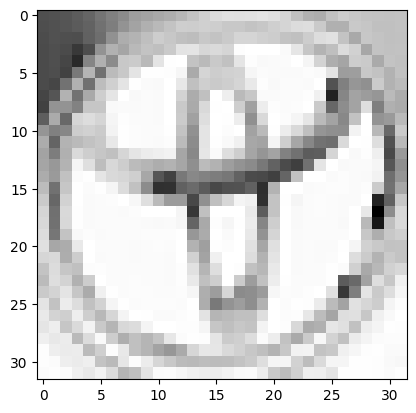

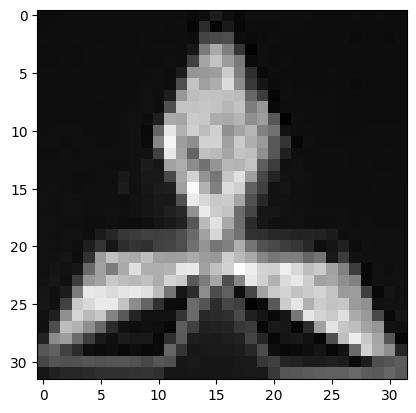

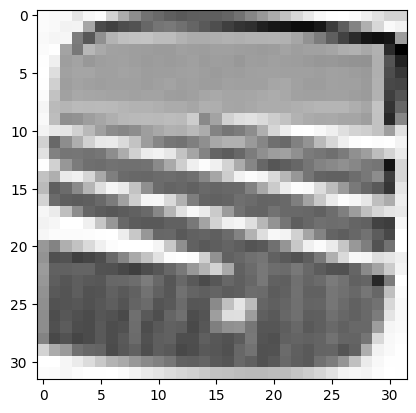

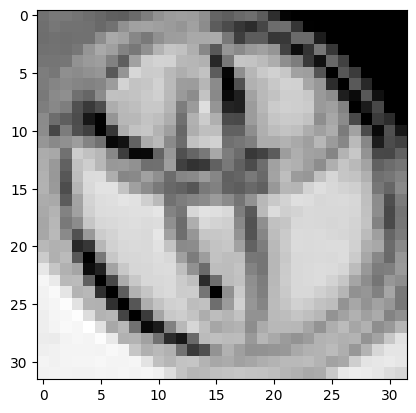

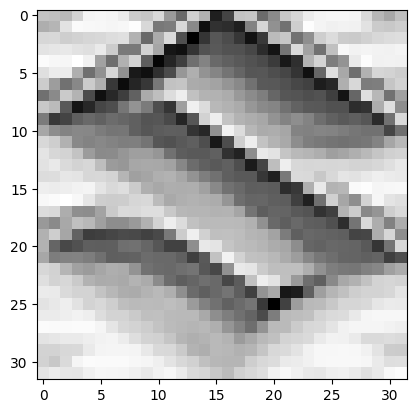

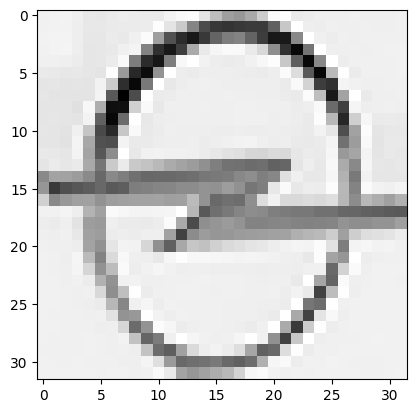

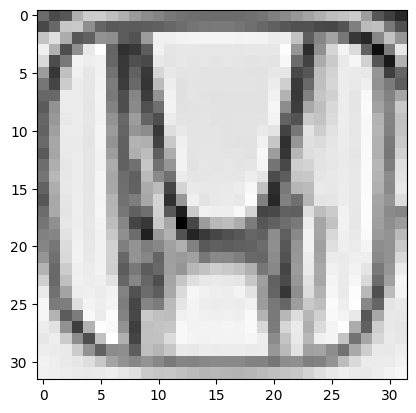

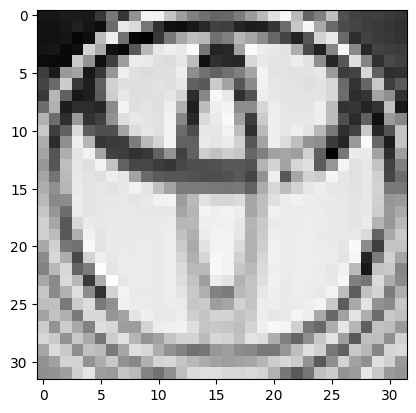

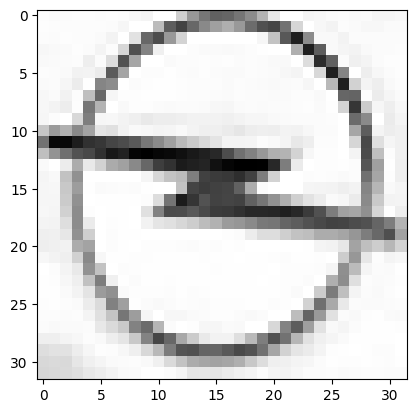

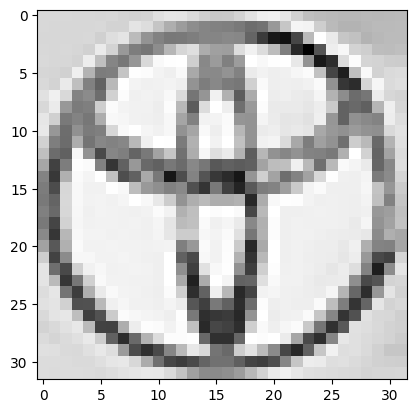

In [25]:
# Let's look at some of the observations
for index in range(10):
    observation = data[index].reshape(32, 32)
    plt.imshow(observation, cmap='gray_r', interpolation='nearest')
    plt.show()

## PCA steps

### (If appropriate) normalize the variables to be in the range 0-1

### Center the data

In [26]:
centered_data = data - np.mean(data, axis=0)

### Compute the covariance matrix

We will also visualize it.

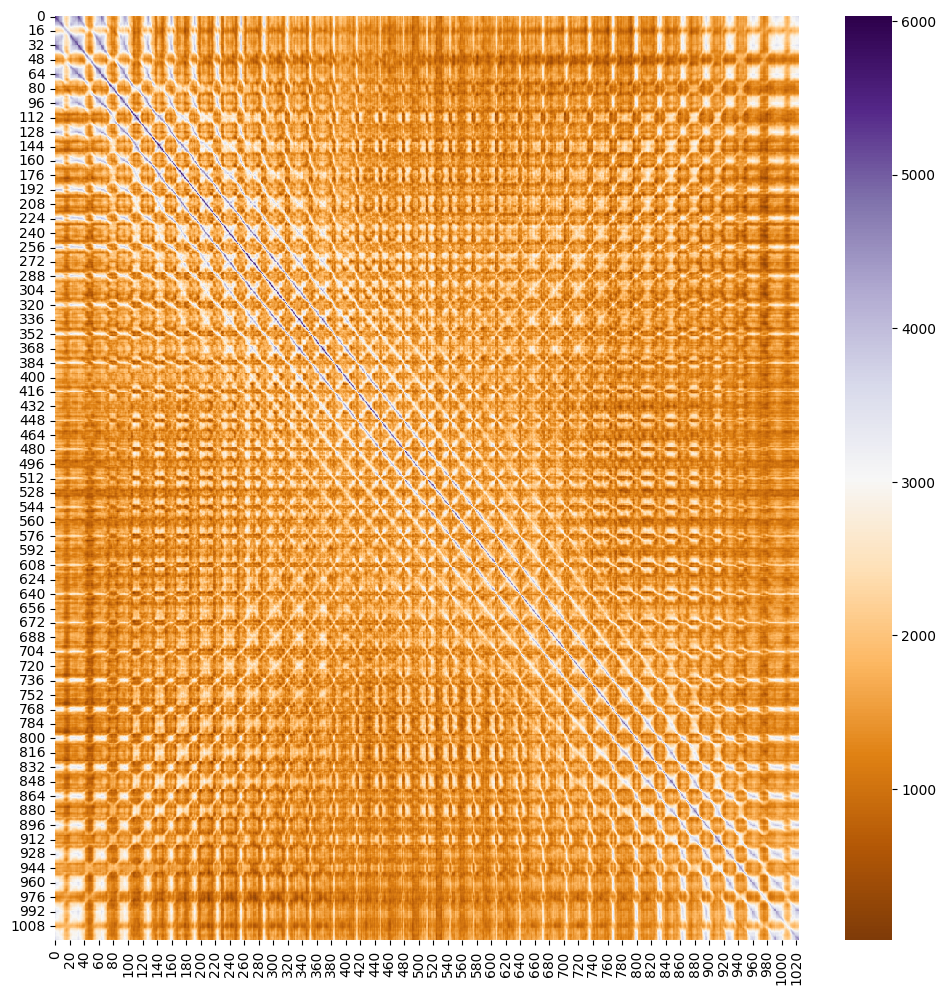

In [27]:
covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)

# Let's look at the covariance matrix
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(covariance_matrix), annot=False, cmap='PuOr')
plt.show()

### Compute the eigenvectors and eigenvalues; Get an ordering over the eigenvalues; Sort the eigenvalues and eigenvectors accordingly

We will also visualize the eigenvectors.

In [28]:
# for this data, when I used numpy's linalg.eig I got errors due to too small numbers, so I use scipy's instead; see https://stackoverflow.com/questions/8765310/scipy-linalg-eig-return-complex-eigenvalues-for-covariance-matrix for more information
evals, evectors = scipy.linalg.eigh(covariance_matrix)

order = np.argsort(evals)[::-1]

eigenvals_sorted = evals[order]
eigenvecs_sorted = evectors[:, order]


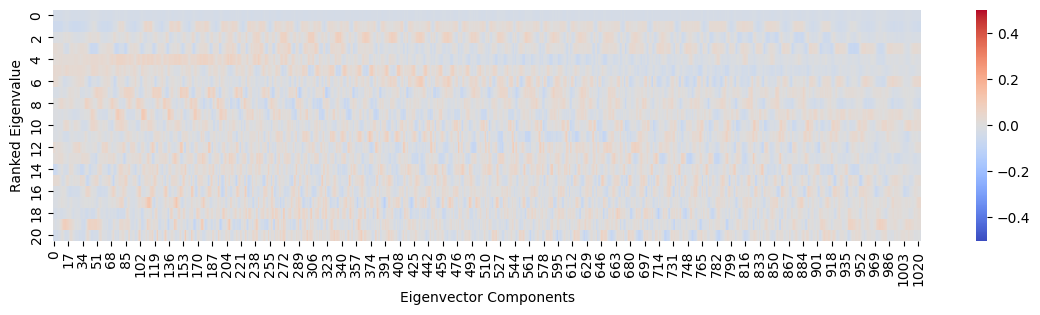

In [29]:
# We can visualize the eigenvectors, sorted by eigenvalue rank, and visually identify which eigenvector components dominate in each eigenvalue. This is essentially a visualization of what information the principal component analysis has judged most important.
fig = plt.figure(figsize=(14,3))
sns.heatmap(pd.DataFrame(eigenvecs_sorted[:, 0:21].T), 
            annot=False, cmap='coolwarm',
           vmin=-0.5,vmax=0.5)

plt.ylabel("Ranked Eigenvalue")
plt.xlabel("Eigenvector Components")
plt.show()

### Compute the proportional variance accounted for by each principal component; Compute the cumulative sum of the proportional variance

In [30]:
sum = np.sum(eigenvals_sorted)
proportional_variances = np.array([eigenvalue / sum for eigenvalue in eigenvals_sorted])
cumulative_sum = np.cumsum(proportional_variances)

### Scree and Elbow plots

These are two plots that will help you move beyond "just keep the eigenvalues that account for 90% of the variance".

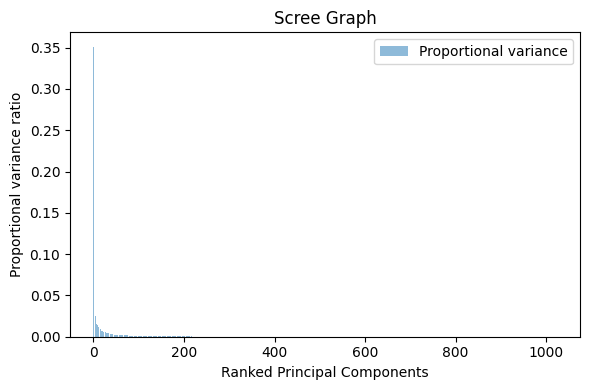

In [31]:
# Let's look at the proportional variance

plt.figure(figsize=(6, 4))

plt.bar(range(len(proportional_variances)), proportional_variances, alpha=0.5, align='center',
        label='Proportional variance')

plt.ylabel('Proportional variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph")

plt.legend(loc='best')
plt.tight_layout()

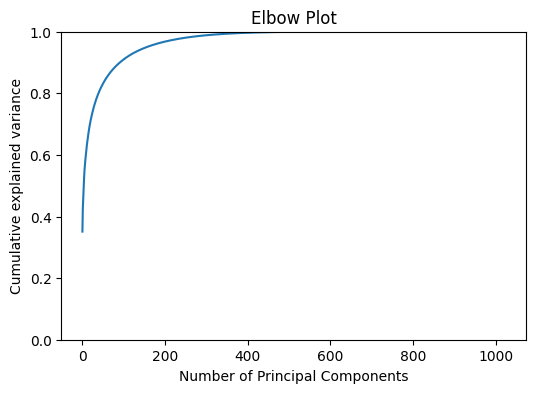

In [32]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(cumulative_sum)

ax1.set_ylim([0,1.0])

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Elbow Plot')

plt.show()

*Looking at this elbow plot, how many principal components do you think we want to keep?*

### Examine the principal components and select some of them; Project the data into PCA space

In [33]:
v = eigenvecs_sorted[:, :144]
projected_data = centered_data@v
print(projected_data.shape)

(544, 144)


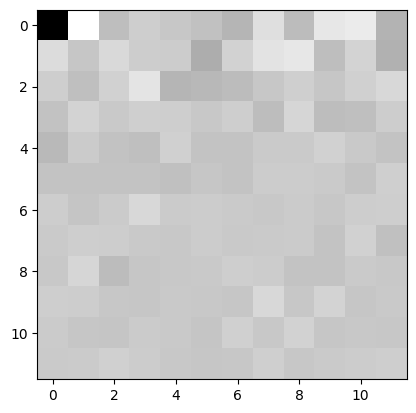

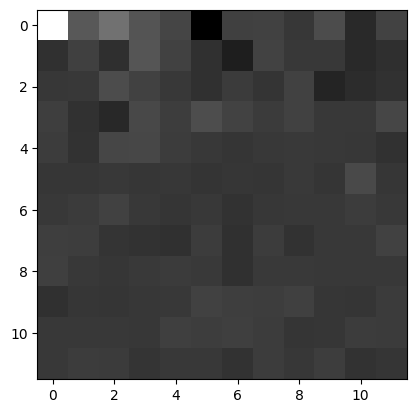

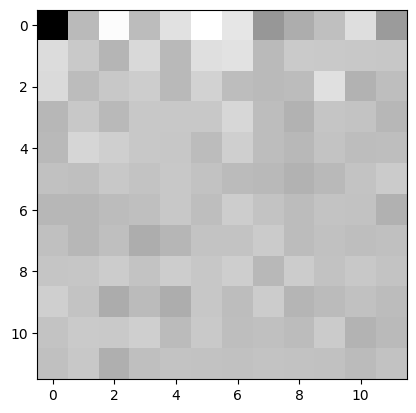

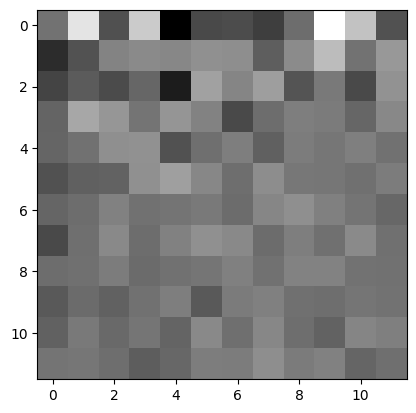

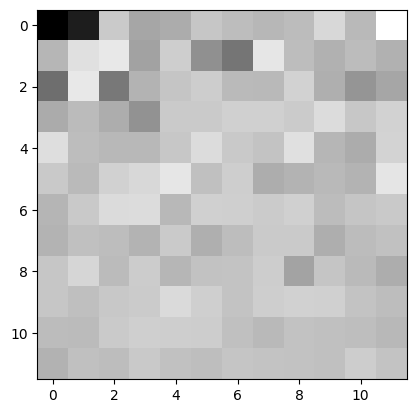

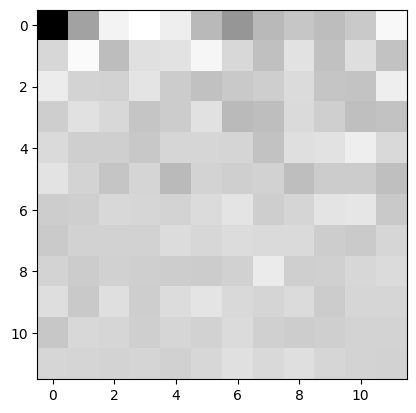

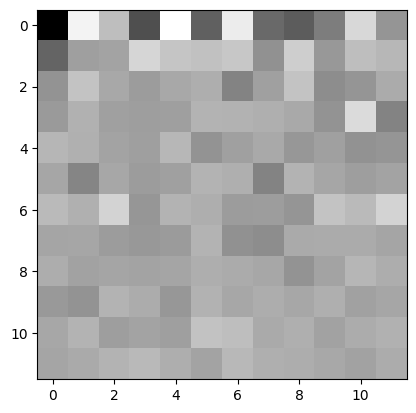

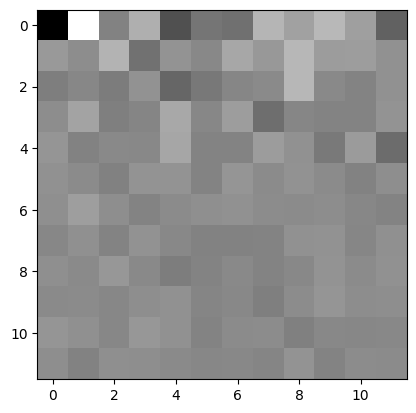

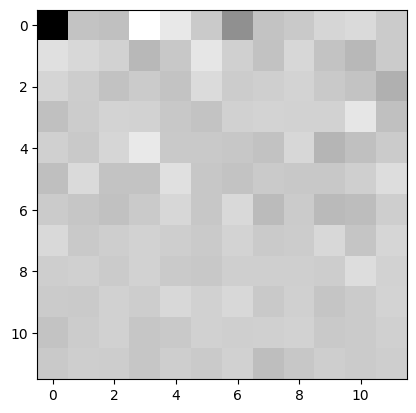

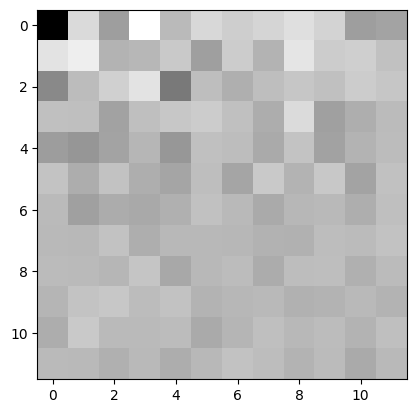

In [34]:
# Let's look at some of the observations
for index in range(10):
    observation = projected_data[index].reshape(12, 12)
    plt.imshow(observation, cmap='gray_r', interpolation='nearest')
    plt.show()

### You can also reconstruct the original data

In [35]:
reconstructed_data = projected_data@v.T + np.mean(data, axis=0)
print(reconstructed_data.shape)

(544, 1024)


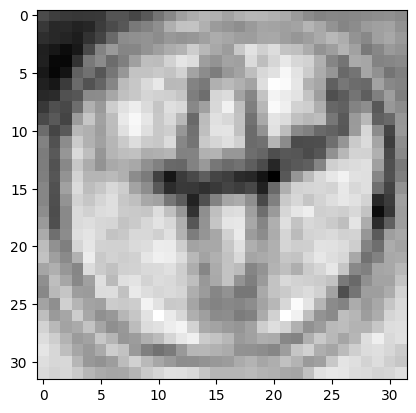

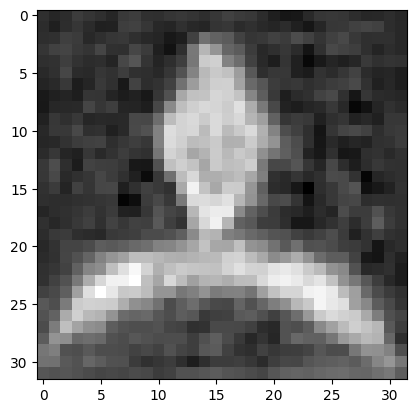

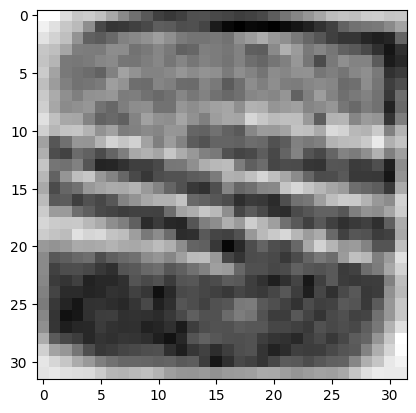

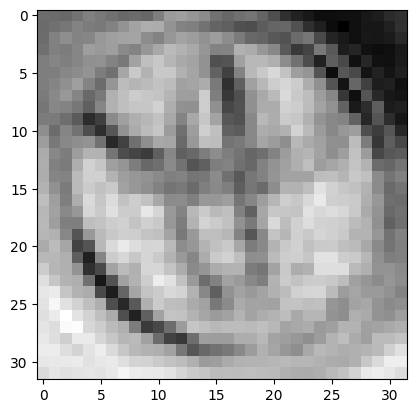

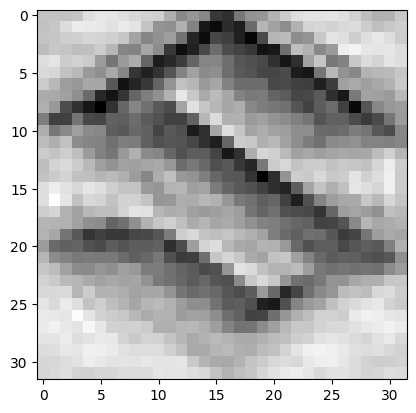

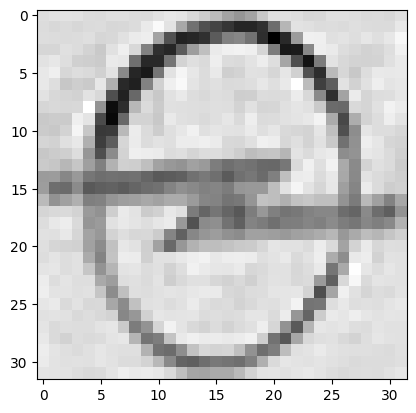

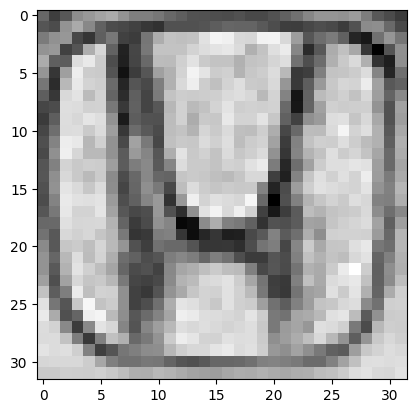

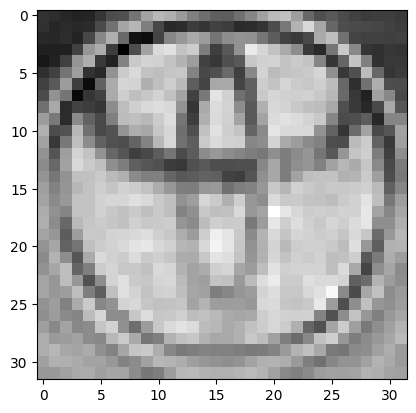

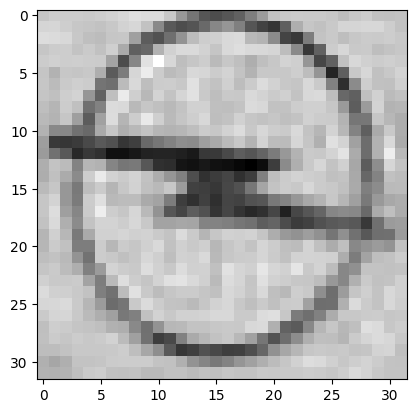

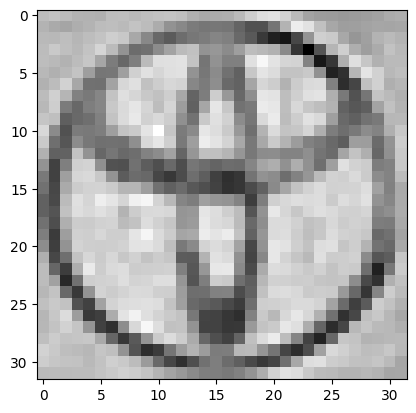

In [36]:
# Let's look at some of the observations
for index in range(10):
    observation = reconstructed_data[index].reshape(32, 32)
    plt.imshow(observation, cmap='gray_r', interpolation='nearest')
    plt.show()

## Want More?

Try this notebook on the dataset "optdigits.tra". This dataset is from https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits and we use just the training data. The pictures are of handwritten digits and they are 8x8. The last column corresponds to the depicted digit. **Make sure to adjust the code accordingly**.

## Resources

* https://www.displayr.com/8-tips-for-interpreting-r-squared/